# Part 1: Text Selection and Acquisition

In [ ]:
# Importing
import requests
import re

# Downloading the book as plain text
url = "https://www.gutenberg.org/cache/epub/55/pg55.txt"
response = requests.get(url)
text = response.text

# Displaying the basic statistics
print(f"Book title: The Wonderful Wizard of Oz")
print(f"Total characters: {len(text):,}")
print(f"Total lines: {len(text.splitlines()):,}")
print(f"File size: {len(text.encode('utf-8')) / 1024:.2f} KB")

Book title: The Wonderful Wizard of Oz
Total characters: 232,206
Total lines: 5,130
File size: 231.72 KB


# Part 2: Text Cleaning with Regular Expressions

In [ ]:
# Removing Project Gutenberg headers and footers using \n to handle line breaks
header_pattern = r"^(.|\n)*\*\*\* START OF THE PROJECT GUTENBERG EBOOK.*\n" # matches all from start of file up to and including "***START..." line
footer_pattern = r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK.*(.|\n)*$" # matches all from "***END..." line through end of file

text = re.sub(header_pattern, "", text) # removing header
text = re.sub(footer_pattern, "", text) # removing footer

# Chapter finding pattern, covers most cases (includes introduction)
chapter_pattern = r"[Ii]ntroduction|[Cc]hapter\s+(?:[IVXLCDM]+|\d+|[A-Za-z-]+)" # (?:) added so that findall returns the full match
chapters = re.findall(chapter_pattern, text)

# Keeping only first occurrence of each chapter to remove duplicates
chapters = list(dict.fromkeys(chapters))

# Cleaning special formatting
text_caps = text # saves original casing for name extraction
text = re.sub(r"[“”]",'"', text) # replacing special character quotations for regular quotations
text = re.sub(r"\s+", " ", text).strip() # removes extra whitespace
text = text.lower() # lowercase all
text = re.sub(r'[_*]+', '', text) # removes underscores, asterisks used for emphasis

# Display results
print(f"Number of chapters found: {len(chapters)}")
print(f"First 5 chapters: {chapters[:5]}")

Number of chapters found: 25
First 5 chapters: ['Introduction', 'Chapter I', 'Chapter II', 'Chapter III', 'Chapter IV']


# Part 3: Text Tokenization and Basic Analysis

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import nltk
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

#1. Tokenization
# Pattern for word tokenization using regex
word_pattern = r"\b\w+\b"
words = re.findall(word_pattern, text)

# Pattern for sentence tokenization using regex
sentence_pattern = r"[^.!?]+[.!?]" # finding punctuation that ends sentences
sentences = re.findall(sentence_pattern, text)

print(f"Number of words: {len(words)}")
print(f"Number of sentences: {len(sentences)}")

#2. Word Frequency Analysis
# Word Frequency Analysis no stopwords
word_freq = Counter(words)
print("Top 20 words:", word_freq.most_common(20))

# Word Frequency Analysis w/ stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [w for w in words if w not in stop_words and w.isalpha()] # filters out stopwords and makes sure characters in the string are alphabet letters
filtered_word_freq = Counter(filtered_words)
print("Top 20 words (no stopwords):", filtered_word_freq.most_common(20))

# Vocabulary size no stopwords
unique_words = set(words)
print(f"Vocabulary size: {len(unique_words)}")

# Vocabulary size w/ stopwords
unique_filtered_words = set(filtered_words)
print(f"Vocabulary size (no stopwords): {len(unique_filtered_words)}")

#3. Pattern Analysis using Regex
# Quoted dialogue
dialogue_pattern = r'"[^"]+"|\'[^\']+\'' # checking for both quotations and apostrophes
dialogues = re.findall(dialogue_pattern, text)
print(f"Number of quoted dialogue: {len(dialogues)}")

# Character Names
name_pattern = r"\b[A-Z][a-z]+\b"
names = re.findall(name_pattern, text_caps)
filtered_names = [n for n in names if n.lower() not in stop_words] # filtering out stopwords that were treated as names
name_counts = Counter(filtered_names)
print(f"Number of character names: {len(name_counts)}")

# Questions
question_pattern = r"[^?]+\?"
questions = re.findall(question_pattern, text)
print(f"Number of questions: {len(questions)}")

# Exclamations
exclamations_pattern = r"[^!]+\!"
exclamations = re.findall(exclamations_pattern, text)
print(f"Number of exclamations: {len(exclamations)}")

Number of words: 40001
Number of sentences: 2255
Top 20 words: [('the', 3004), ('and', 1671), ('to', 1118), ('of', 847), ('a', 807), ('i', 649), ('was', 504), ('you', 495), ('in', 483), ('he', 457), ('it', 426), ('her', 410), ('they', 403), ('she', 398), ('that', 395), ('dorothy', 369), ('said', 332), ('as', 329), ('for', 328), ('so', 307)]
Top 20 words (no stopwords): [('dorothy', 369), ('said', 332), ('scarecrow', 225), ('woodman', 183), ('lion', 180), ('oz', 164), ('great', 142), ('tin', 140), ('little', 139), ('witch', 129), ('one', 126), ('could', 120), ('asked', 114), ('would', 113), ('green', 104), ('came', 104), ('good', 102), ('back', 98), ('see', 95), ('girl', 94)]
Vocabulary size: 2934
Vocabulary size (no stopwords): 2794
Number of quoted dialogue: 1074
Number of character names: 260
Number of questions: 194
Number of exclamations: 97


# Part 4: Document Representation and Similarity

In [ ]:
import numpy as np
import pandas as pd

# Finding chapter boundaries for sections
ch1 = re.search(r"chapter i the cyclone", text).start()
ch2 = re.search(r"chapter ii the council with the munchkins", text).start()
ch3 = re.search(r"chapter iii how dorothy saved the scarecrow", text).start()
ch4 = re.search(r"chapter iv the road through the forest", text).start()

# Slicing sections
section1 = text[ch1:ch2]
section2 = text[ch2:ch3]
section3 = text[ch3:ch4]
sections = [section1, section2, section3]

# Tokenizing with regex to stay consistent (using word_pattern from earlier)
section_tokens = [re.findall(word_pattern, section) for section in sections]

# Extra analysis (No stopwords)
section_tokens_no = [[w for w in tokens if w not in stop_words] for tokens in section_tokens]

# Bag of Words Class creation
class BagOfWords:

  def __init__(self):
    self.vocabulary = {}
    self.vocab_size = 0

  def fit(self, tokenized_sections):
    vocab_set = set()
    for tokens in tokenized_sections:
      vocab_set.update(tokens)

    self.vocabulary = {word: i for i, word in enumerate(sorted(vocab_set))}
    self.vocab_size = len(self.vocabulary)
    return self

  def transform(self, tokenized_sections):
    vectors = np.zeros((len(tokenized_sections), self.vocab_size))

    for i, tokens in enumerate(tokenized_sections):
      for word in tokens:
        if word in self.vocabulary:
          word_i = self.vocabulary[word]
          vectors[i, word_i] += 1
    return vectors

  def fit_transform(self, tokenized_sections):
    self.fit(tokenized_sections)
    return self.transform(tokenized_sections)

# Getting a count of top 10 words in all sections
bow = BagOfWords()
bow_vectors = bow.fit_transform(section_tokens)

all_words = [w for s in section_tokens for w in s]
top_10_words = Counter(all_words).most_common(10)

print("Top 10 words:", top_10_words)

# Getting counts per section
top_words = [w for w, _ in top_10_words if w in bow.vocabulary]
cols_idx = [bow.vocabulary[w] for w in top_words]

df = pd.DataFrame(
    bow_vectors[:, cols_idx].astype(int),
    index=[f"Section {i+1}" for i in range(len(section_tokens))],
    columns=top_words
)

print("Counts per section (top 10 words):")
print(df.T)

# Building Cosine Similarity
def cosine_similarity(vec1, vec2):
  dot_product = np.dot(vec1, vec2)
  norm1 = np.linalg.norm(vec1)
  norm2 = np.linalg.norm(vec2)

  if norm1 == 0 or norm2 == 0:
    return 0.0
  return dot_product / (norm1 * norm2)

# Calculating similarities
n_docs = len(bow_vectors)
cosine_matrix = np.zeros((n_docs, n_docs))

for i in range(n_docs):
  for j in range(n_docs):
    cosine_matrix[i, j] = cosine_similarity(bow_vectors[i], bow_vectors[j])

# Displaying results
labels = ["Section 1", "Section 2", "Section 3"]

print("\nCosine Similarity Matrix:")
print("         "+"   ".join(labels))
for i, row in enumerate(cosine_matrix):
  row_str = "      ".join(f"{val:.4f}" for val in row) # keeping to 4 decimal places for clean output
  print(f"{labels[i]:<9} {row_str}")

print("\nPairwise Similarities:")
print(f"Section 1 - Section 2: {cosine_matrix[0, 1]:.4f}")
print(f"Section 1 - Section 3: {cosine_matrix[0, 2]:.4f}")
print(f"Section 2 - Section 3: {cosine_matrix[1, 2]:.4f}")

Top 10 words: [('the', 386), ('and', 214), ('a', 124), ('to', 122), ('of', 106), ('she', 96), ('her', 93), ('dorothy', 73), ('was', 73), ('in', 72)]
Counts per section (top 10 words):
         Section 1  Section 2  Section 3
the             98        161        127
and             63         72         79
a               28         46         50
to              18         42         62
of              20         53         33
she             22         29         45
her             20         39         34
dorothy         17         31         25
was             23         23         27
in              20         30         22

Cosine Similarity Matrix:
         Section 1   Section 2   Section 3
Section 1 1.0000      0.8937      0.8778
Section 2 0.8937      1.0000      0.9225
Section 3 0.8778      0.9225      1.0000

Pairwise Similarities:
Section 1 - Section 2: 0.8937
Section 1 - Section 3: 0.8778
Section 2 - Section 3: 0.9225


In [ ]:
# Extra analysis, what if we filter out stopwords?
bow_no = BagOfWords()
bow_vectors_no = bow_no.fit_transform(section_tokens_no)

all_words_no = [w for s in section_tokens_no for w in s]
top_10_words_no = Counter(all_words_no).most_common(10)
print("Top 10 words (no stopwords):", top_10_words_no)

top_words_no = [w for w, _ in top_10_words_no if w in bow_no.vocabulary]
cols_idx_no = [bow_no.vocabulary[w] for w in top_words_no]

df_no = pd.DataFrame(
    bow_vectors_no[:, cols_idx_no].astype(int),
    index=[f"Section {i+1}" for i in range(len(section_tokens_no))],
    columns=top_words_no
)
print("Counts per section (top 10 words, no stopwords):")
print(df_no.T)

n_docs = len(bow_vectors_no)
cosine_matrix = np.zeros((n_docs, n_docs))

for i in range(n_docs):
  for j in range(n_docs):
    cosine_matrix[i, j] = cosine_similarity(bow_vectors_no[i], bow_vectors_no[j])

labels = ["Section 1", "Section 2", "Section 3"]

print("\nCosine Similarity Matrix:")
print("         "+"   ".join(labels))
for i, row in enumerate(cosine_matrix):
  row_str = "      ".join(f"{val:.4f}" for val in row)
  print(f"{labels[i]:<9} {row_str}")

print("\nPairwise Similarities:")
print(f"Section 1 - Section 2: {cosine_matrix[0, 1]:.4f}")
print(f"Section 1 - Section 3: {cosine_matrix[0, 2]:.4f}")
print(f"Section 2 - Section 3: {cosine_matrix[1, 2]:.4f}")

Top 10 words (no stopwords): [('dorothy', 73), ('little', 38), ('witch', 30), ('said', 28), ('toto', 27), ('house', 24), ('one', 21), ('girl', 18), ('great', 16), ('oz', 16)]
Counts per section (top 10 words, no stopwords):
         Section 1  Section 2  Section 3
dorothy         17         31         25
little           5         25          8
witch            0         23          7
said             0         14         14
toto            10          3         14
house           11          9          4
one              6         10          5
girl             3          7          8
great            5          6          5
oz               0          8          8

Cosine Similarity Matrix:
         Section 1   Section 2   Section 3
Section 1 1.0000      0.4406      0.4075
Section 2 0.4406      1.0000      0.6177
Section 3 0.4075      0.6177      1.0000

Pairwise Similarities:
Section 1 - Section 2: 0.4406
Section 1 - Section 3: 0.4075
Section 2 - Section 3: 0.6177


### **What the similarities tell you about the content**
With stopwords included, the sections appear to be very similar (cosine scores of around 0.9). Common words like _the, and, a_ repeat the most, masking real differences in each section.

Once stopwords are removed, the similarities have a significant drop (cosine scores of around 0.40-0.61). The vectors show more meaningful terms like _dorothy, little, and witch_. Removing the stopwords helps reflect the differences in actual story content rather than the background structure of English.

# Part 5: Insights and Visualization

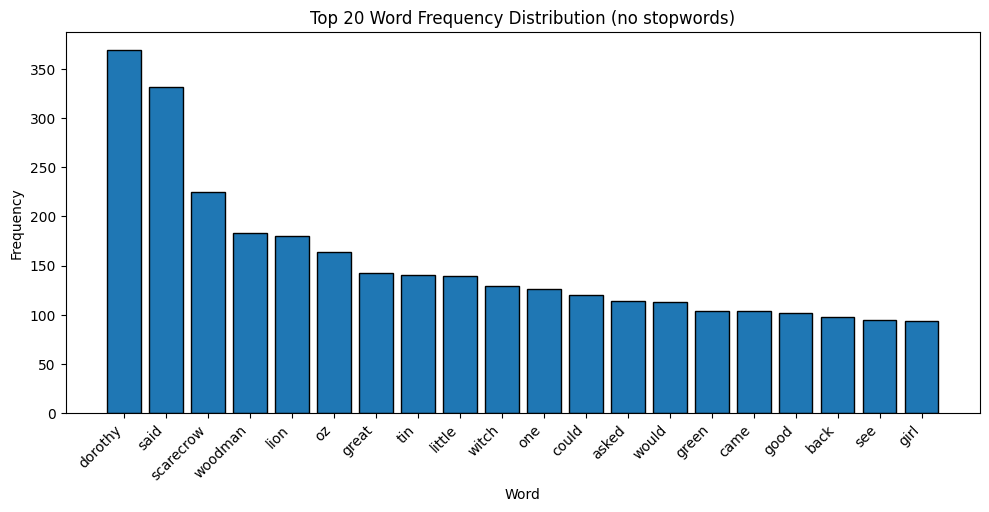

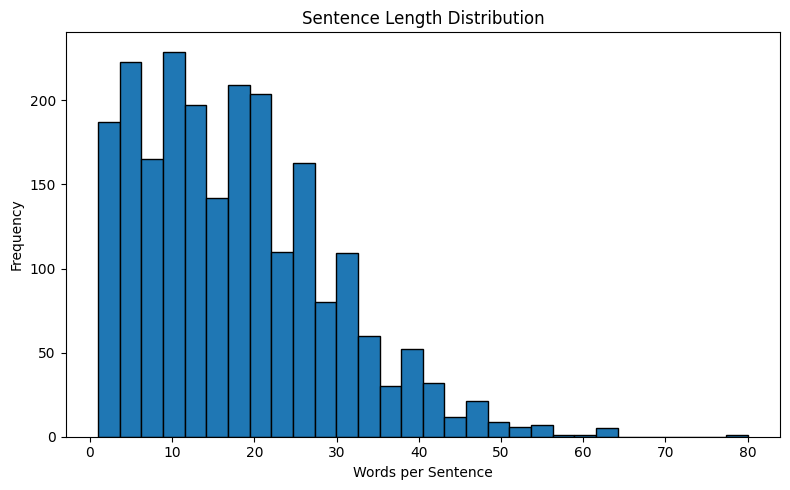

In [ ]:
import matplotlib.pyplot as plt

# Word frequency distribution (top 20 words, no stopwords)
top20 = filtered_word_freq.most_common(20)
words, counts = zip(*top20)

plt.figure(figsize=(10,5))
plt.bar(words, counts, edgecolor="black")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.tight_layout()
plt.title('Top 20 Word Frequency Distribution (no stopwords)')
plt.show()

# Sentence length distribution
sentence_lengths = [len(re.findall(word_pattern, s)) for s in sentences]

plt.figure(figsize=(8,5))
plt.hist(sentence_lengths, bins=30, edgecolor="black")
plt.title("Sentence Length Distribution")
plt.xlabel("Words per Sentence")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### **Brief Summary of my Findings**
In The Wonderful Wizard of Oz, some clear patterns stood out. Once stopwords are removed, the most frequent words are names and story terms like *Dorothy, Scarecrow, Woodman, and Lion*. This confirms that the text revolves around its main characters.

The sentence length chart shows most sentences are short, under 50 words, while some groups stretch towards 80. The short sentences keep the story easy to follow, and the longer sentences are able to provide room for description and scene-setting.

---

Regular expressions worked well for this project. They made it straightforward to clean the Gutenberg text, normalize quotes and spaces, and pull out patterns (like dialogue, questions, and exclamations).

Regex had its limitations though, it was challenging to look for names. Regex labeled sentence starters or cities as characters. It was also difficult to parse sentences by length due to the many edge cases punctuation can have in natural language. That shows that regex is strong for structure but less precise for meaning. For greater accuracy, more advanced NLP methods would be needed.